In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

In [5]:
# 讀取訓練資訊，根據 player_id 將資料分成 80% 訓練、20% 測試
info = pd.read_csv('train_info.csv')
unique_players = info['player_id'].unique()
train_players, test_players = train_test_split(unique_players, test_size=0.2, random_state=42)
    
# 讀取特徵 CSV 檔（位於 "./tabular_data_train"）
datapath = './tabular_data_train'
datalist = list(Path(datapath).glob('**/*.csv'))
target_mask = ['gender', 'hold racket handed', 'play years', 'level']
    
# 根據 test_players 分組資料
X_train = pd.DataFrame()
y_train = pd.DataFrame(columns=target_mask)
X_test = pd.DataFrame()
y_test = pd.DataFrame(columns=target_mask)
    
for file in datalist:
    unique_id = int(Path(file).stem)
    row = info[info['unique_id'] == unique_id]
    if row.empty:
        continue
    player_id = row['player_id'].iloc[0]
    data = pd.read_csv(file)
    mode = info.loc[info['unique_id'] == unique_id, 'mode'].values[0] # a scalar
    mode_onehot = np.zeros((1))
    mode_onehot[0] = 1 if mode >= 9 else 0
    # mode_onehot[mode - 1] = 1 # mode : 1-10
    mode_onehot = pd.DataFrame([mode_onehot] * len(data))
    # from GPT ==================================
    # 查看目前有幾列
    num_rows = len(data)

    # 如果不足 27 列，就補 0 到達 27 列
    if num_rows < 27:
        print('bug')
        num_missing = 27 - num_rows
        missing_rows = pd.DataFrame(0, index=range(num_missing), columns=data.columns)
        data = pd.concat([data, missing_rows], ignore_index=True)
    # from GPT ==================================

    target = row[target_mask]
    target_repeated = pd.concat([target] * len(data))
    data = pd.concat([data, mode_onehot], axis=1)
    if player_id in train_players:
        X_train = pd.concat([X_train, data], ignore_index=True)
        y_train = pd.concat([y_train, target_repeated], ignore_index=True)
    elif player_id in test_players:
        X_test = pd.concat([X_test, data], ignore_index=True)
        y_test = pd.concat([y_test, target_repeated], ignore_index=True)
print('train shape', X_train.shape)
print('test shape', X_test.shape)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

train shape (42039, 35)
test shape (10746, 35)


<Axes: >

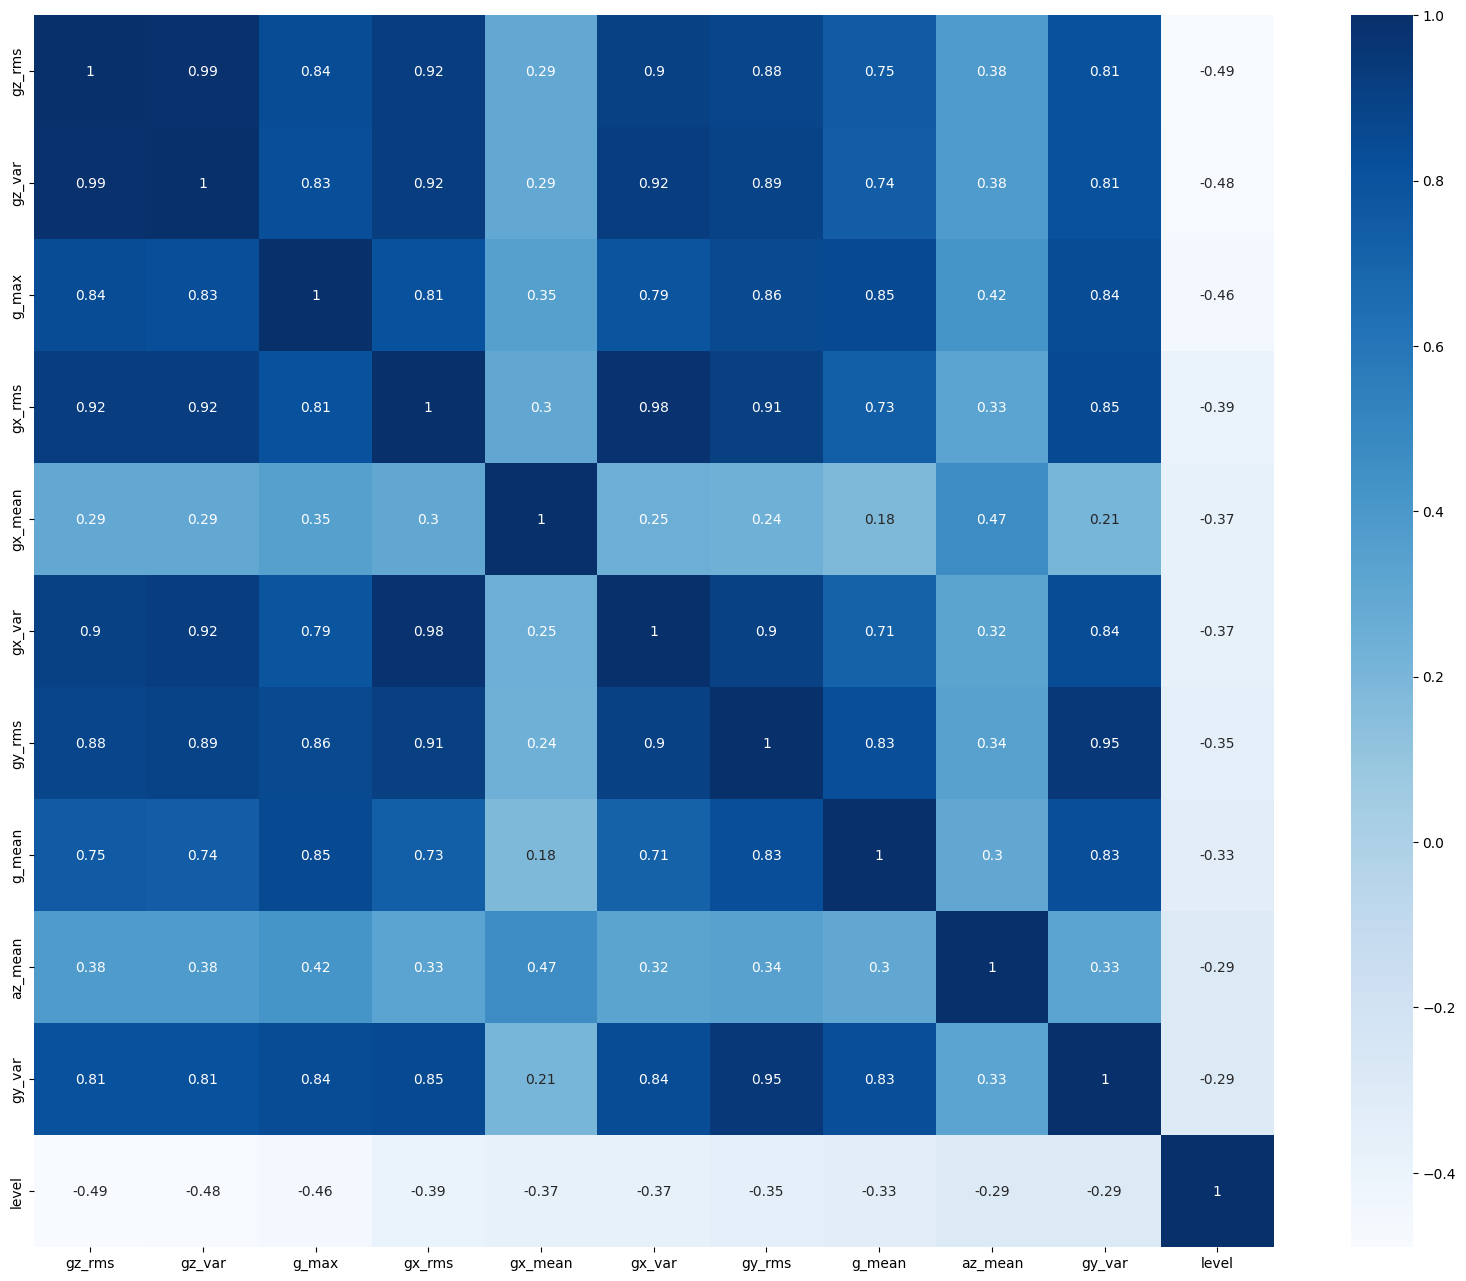

In [6]:
plt.figure(figsize=(20, 16))  # 自訂圖表大小（寬, 高）
tmp_X_train = X_train.copy()
target = 'level'
tmp_X_train[target] = y_train[target]
correlation_matrix = tmp_X_train.corr().round(2)

# 計算與 level 的相關係數，排序後取前10名（排除 level 自身）
top_corr_features = correlation_matrix[target].abs().sort_values(ascending=False).drop(target).head(10).index

# 把這些特徵 + level 拿出來重算相關矩陣
top_corr_matrix = tmp_X_train[top_corr_features.tolist() + [target]].corr().round(2) # 

# 畫圖
sns.heatmap(data=top_corr_matrix, annot=True, cmap='Blues')

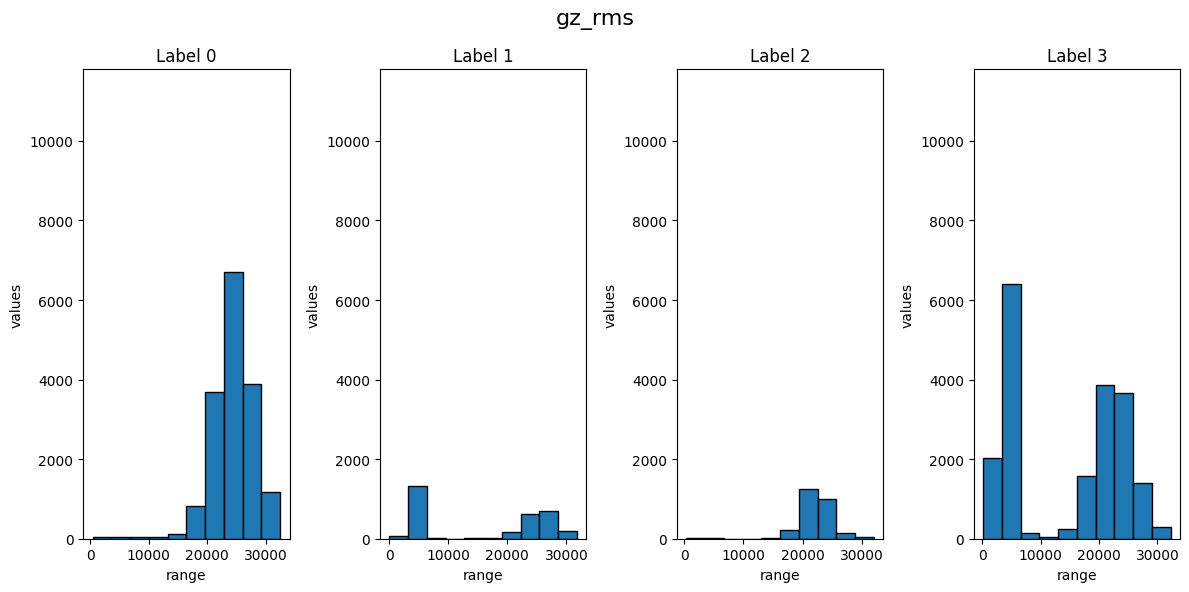

In [77]:
feature_target = 'gz_rms'
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
for i in range(2, 6):
    axes[i - 2].set_title(f'Label {i - 2}')
    axes[i - 2].hist(X_train[feature_target][y_train['level'] == i], bins=10, edgecolor='black')
    axes[i - 2].set_xlabel('range')
    axes[i - 2].set_ylabel('values')
    axes[i - 2].set_ylim(0, 11800)
fig.suptitle(feature_target, fontsize=16)
plt.tight_layout()
plt.show()

In [78]:
# # 假設 'level' 是目標變數，且你想畫 'gz_var' 特徵的分布
# plt.figure(figsize=(10, 6))

# # 合併 'gz_var' 和 'level' 為一個 DataFrame
# target_data = X_train
# label = LabelEncoder().fit_transform(y_train['level'])
# target_data = LinearDiscriminantAnalysis().fit_transform(target_data, label)

# for f in list(X_train.columns):
#     plot_data = pd.DataFrame({
#         'LDA': X_train[f],  # 特徵
#         'level': label     # 類別
#     })

#     # 使用 seaborn 畫出四類的 KDE，並且疊在一起
#     custom_palette = ['#FF6347', '#3CB371', '#1E90FF', '#8A2BE2']  # 自定義顏色
#     sns.kdeplot(data=plot_data, x='LDA', hue='level', common_norm=False, fill=True, palette=custom_palette)

#     plt.title(f'{f}')
#     plt.xlabel('LDA')
#     plt.ylabel('Density')
#     plt.savefig(f'img/{f}.png')
#     plt.close()


## Start

### Normalize

In [212]:
def normalize(name, bound=10, mode=0, X_train=None, X_test=None):
    X_corr = X_train.apply(lambda col: col.corr(y_train[name]))
    X_corr = X_corr.sort_values(ascending=False)
        
    if mode == 1: # pos
        columns = X_corr.head(bound).index.tolist()
    elif mode == 2: # neg
        columns = X_corr.tail(bound).index.tolist()
        
    if mode == 0:
        X_train_func = X_train
        X_test_func = X_test
    elif mode == 1:
        X_train_func = X_train[columns]
        X_test_func = X_test[columns]
    elif mode == 2:
        X_train_func = X_train.drop(columns=columns)
        X_test_func = X_test.drop(columns=columns)
            
    scaler = PowerTransformer()
    X_train_scaled = scaler.fit_transform(X_train_func)
    X_test_scaled = scaler.transform(X_test_func)
    return X_train_scaled, X_test_scaled

### model_multiary

In [213]:
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.svm import SVC
import shap

In [230]:
# 定義多類別分類評分函數 (例如 play years、level)
def model_multiary(X_train, y_train, X_test, y_test, group_size=27):
    print('Start')
    # clf = RandomForestClassifier(random_state=42, n_jobs=-1, criterion='entropy', class_weight='balanced')
    clf = HistGradientBoostingClassifier(warm_start=True, l2_regularization=1e-1, max_iter=300, random_state=42, class_weight='balanced')
    # clf = GaussianNB()
    
    # clf = lgb.LGBMClassifier(
    #     n_estimators=200,
    #     learning_rate=0.1,
    #     max_depth=3,
    #     random_state=42,
    #     early_stopping_rounds=10,
    #     class_weight='balanced',
    #     verbosity=-1
    # )
    # clf.fit(X_train, y_train,
    #         eval_set=[(X_test, y_test)],
    #         eval_metric="multi_logloss",
    #         )
    clf.fit(X_train, y_train)
    
    # 以 lightGBM 為例
    # explainer = shap.TreeExplainer(clf)
    # shap_values = explainer.shap_values(X_train)

    # # 如果是 multi-class，shap_values 是一個 list：每一類別一個 ndarray
    # # shap_values[2] 對應的是 label 2
    # for i in range(shap_values.shape[-1]):
    #     shap.summary_plot(shap_values[:, :, i], X_train) 
    
    predicted = clf.predict_proba(X_test)
    num_groups = len(predicted) // group_size
    y_pred = []
    for i in range(num_groups):
        group_pred = predicted[i*group_size: (i+1)*group_size]
        num_classes = len(np.unique(y_train))
        # 對每個類別計算該組內的總機率
        class_sums = [sum([group_pred[k][j] for k in range(group_size)]) for j in range(num_classes)]
        chosen_class = np.argmax(class_sums)
        candidate_probs = [group_pred[k][chosen_class] for k in range(group_size)]
        best_instance = np.argmax(candidate_probs)
        y_pred.append(group_pred[best_instance])
        
    y_test_agg = [y_test[i*group_size] for i in range(num_groups)]
    auc_score = roc_auc_score(y_test_agg, y_pred, average='micro', multi_class='ovr')
    class_report = classification_report(y_test_agg, np.argmax(y_pred, axis=1))
    print(f'Multiary AUC: {auc_score:.4f}')
    print('class report')
    print(class_report)
    cm = confusion_matrix(y_test_agg, np.argmax(y_pred, axis=1))
    sns.heatmap(cm, fmt='d', annot=True, cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    print('==========================')
    
    # return shap_values

### Start
#### Data

In [251]:
le = LabelEncoder()
y_train_encode = le.fit_transform(y_train[target])
y_test_encode = le.transform(y_test[target])

lda = LinearDiscriminantAnalysis()
X_train_scaled, X_test_scaled = normalize(target, 10, mode=0, X_train=X_train, X_test=X_test)
# X_train_reduced = lda.fit_transform(X_train_scaled, y_train_encode)
# X_test_reduced = lda.transform(X_test_scaled)

X_train_reduced = np.log(X_train_scaled[:, 3].reshape(-1, 1))
X_test_reduced = np.log(X_test_scaled[:, 3].reshape(-1, 1))

C:\Users\wendy\AppData\Local\Temp\ipykernel_21320\2282618691.py:10: RuntimeWarning: invalid value encountered in log
  X_train_reduced = np.log(X_train_scaled[:, 3].reshape(-1, 1))
C:\Users\wendy\AppData\Local\Temp\ipykernel_21320\2282618691.py:11: RuntimeWarning: invalid value encountered in log
  X_test_reduced = np.log(X_test_scaled[:, 3].reshape(-1, 1))


Max nan
Min nan


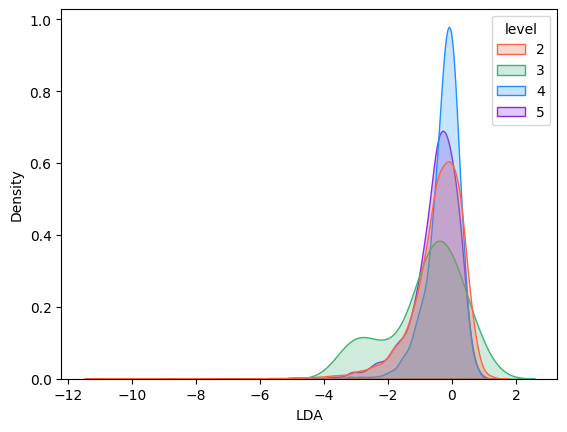

In [252]:
plot_data = pd.DataFrame({
    'LDA': X_train_reduced.reshape(-1),  # 特徵
    'level': y_train['level']     # 類別
})

# 使用 seaborn 畫出四類的 KDE，並且疊在一起
custom_palette = ['#FF6347', '#3CB371', '#1E90FF', '#8A2BE2']  # 自定義顏色
sns.kdeplot(data=plot_data, x='LDA', hue='level', common_norm=False, fill=True, palette=custom_palette)

print('Max', X_train_reduced.max())
print('Min', X_train_reduced.min())

plt.xlabel('LDA')
plt.ylabel('Density')
plt.show()
plt.close()

In [253]:
print(X_train_reduced.shape)
print(X_test_reduced.shape)

(42039, 1)
(10746, 1)


In [254]:
# for i in range(X_train_reduced.shape[1]):
#     plot_data = pd.DataFrame({
#         'LDA': X_train_reduced[:, i],  # 特徵
#         'level': y_train_encode     # 類別
#     })

#     # 使用 seaborn 畫出四類的 KDE，並且疊在一起
#     custom_palette = ['#FF6347', '#3CB371', '#1E90FF', '#8A2BE2']  # 自定義顏色
#     sns.kdeplot(data=plot_data, x='LDA', hue='level', common_norm=False, fill=True, palette=custom_palette)

#     plt.title(f'{i}')
#     plt.xlabel('LDA')
#     plt.ylabel('Density')
#     plt.show()


#### Run

Start
Multiary AUC: 0.8205
class report
              precision    recall  f1-score   support

           0       0.89      0.48      0.62       101
           1       0.33      1.00      0.49        86
           2       0.37      0.83      0.51        36
           3       0.00      0.00      0.00       175

    accuracy                           0.41       398
   macro avg       0.40      0.58      0.41       398
weighted avg       0.33      0.41      0.31       398



d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


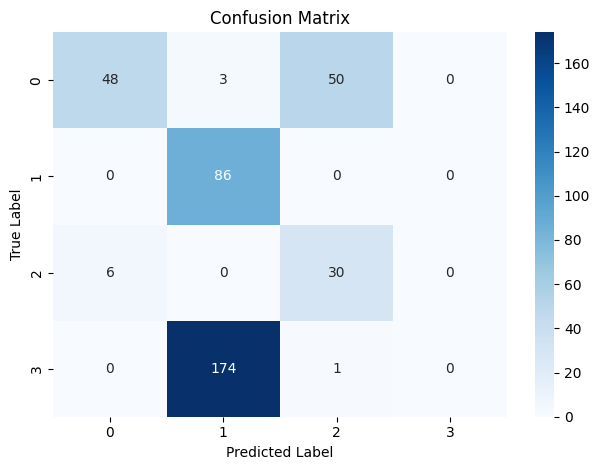

In [255]:
shap_values = model_multiary(X_train_reduced, y_train_encode, X_test_reduced, y_test_encode)

### Outcome

In [256]:
# feature_index = list(X_train.columns).index("gx_mean")

# # 針對 label 2，畫出 gx_mean 的 SHAP 值分布
# shap.dependence_plot(
#     feature_index,                # 或直接用 "gx_mean"
#     shap_values[:, :, 2],               # label 2 的 SHAP 值
#     X_train,
#     #interaction_index=None       # 不顯示交互作用
# )